# Preprocessing Sentinel-2 images

The *Copernicus Sentinel-2* mission comprises a constellation of two polar-orbiting satellites placed in the same sun-synchronous orbit, phased at 180° to each other. It aims at monitoring variability in land surface conditions, and its wide swath width (290 km) and high revisit time (10 days at the equator with one satellite, and 5 days with 2 satellites under cloud-free conditions which results in 2-3 days at mid-latitudes) will support monitoring of Earth's surface changes.

Before strating this notebook, you should download a Sentinel-2 Level-2A product in <a href="https://scihub.copernicus.eu/dhus/#/home" target="_blank">Copernicus Open Access Hub</a>. The L2A products are downloadable by tiles which are 100x100 km2 ortho-images in UTM/WGS84 projection.

The different preprocessing step are as following :

1. Resample images at 20m to 10m (if you want to work with Red, Green, Blue, NIR bands)
2. Clip images to the extent of Region of Interest (ROI)
3. Apply Scene Classification map (SCL) on reflectance images to mask invalid pixels

<img src="figures/prepro_S2.png" width="1000">

In [1]:
import glob, os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.enums import Resampling
from rasterio import plot
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

print(f'Numpy : {np.__version__}')
print(f'Pandas : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')
print(f'Rasterio : {rasterio.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')

Numpy : 1.19.2
Pandas : 1.1.5
GeoPandas : 0.8.1
Rasterio : 1.1.0
Matplotlib : 3.3.4


## Set paths for input and output directories

In [2]:
grp_letter   = 'X'
student_name = 'ndeffense'

# When you are connected to the computer room
'''
raster_path = 'X:/data/RASTER/'
vector_path = 'X:/data/VECTOR/'
output_path = f'X:/GROUP_{grp_letter}/TP/{student_name}/DATA/'
'''

# When you are connected to your personnal computer
raster_path = '/Volumes/nbdid-sst-lbrat2104/data/RASTER/'
vector_path = '/Users/Nicolas/OneDrive - UCL/LBRAT2104/VECTOR/'
output_path = '/Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/'


L2A_path = f'{raster_path}S2B_MSIL2A_20200731T103629_N0214_R008_T31UFS_20200731T140558.SAFE/GRANULE/L2A_T31UFS_A017766_20200731T104607/IMG_DATA/'


print(f'Vector input path is set to : {vector_path}')
print(f'Raster input path is set to : {raster_path}')
print(f'Output path is set to       : {output_path}')

# Directory to store resampled images
resampled_path = f'{output_path}RESAMPLED/'

# Directory to store clipped images
clipped_path = f'{output_path}CLIPPED/'

Path(resampled_path).mkdir(parents=True, exist_ok=True)
Path(clipped_path).mkdir(parents=True, exist_ok=True)

Vector input path is set to : /Users/Nicolas/OneDrive - UCL/LBRAT2104/VECTOR/
Raster input path is set to : /Volumes/nbdid-sst-lbrat2104/data/RASTER/
Output path is set to       : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/


## 1. Resample images at 20m resolution to 10m

### 1.1 Resample Scene Classification map

Only if you are planning to work at 10m resolution. If you are planning to work at 20m resolution, you can skip this step.

In [3]:
# Filenames
# ---------

im_file_20m = f'{L2A_path}R20m/T31UFS_20200731T103629_SCL_20m.jp2'
im_file_10m = f'{resampled_path}T31UFS_20200731T103629_SCL_10m.tif'

# Parameters
# ----------

# We will upscale the image by 2: 20m --> 10m
upscale_factor = 2

# As SCL is categorical data, we must use "nearest neighbor" resampling method
resampling_method = Resampling.nearest

# RESAMPLE
# --------

# Open file
src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

# Resample data to target shape
resampled_data = src.read(out_shape=(src.count,
                           int(src.height * upscale_factor),
                           int(src.width * upscale_factor)
                           ),
                          resampling=resampling_method
                          )

# Scale image transform
new_transform = src.transform * src.transform.scale(
    (src.width / resampled_data.shape[-1]),
    (src.height / resampled_data.shape[-2])
)

# Update metadata
profile = src.profile
profile.update(driver='GTiff',
               width=src.width*upscale_factor,
               height=src.height*upscale_factor,
               transform=new_transform)


# Write resampled image
dst = rasterio.open(im_file_10m, "w", **profile)
dst.write(resampled_data)

# Close rasterio objects
src.close()
dst.close()


print(f'--> A new resampled raster file is created : {im_file_10m}')

--> A new resampled raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/RESAMPLED/T31UFS_20200731T103629_SCL_10m.tif


### 1.2 Resample Bottom-Of-Atmosphere corrected reflectance

If you work only with Blue (B02), Green (B03), Red (B04) and NIR (B08) bands, you don't have to do the resampling step because theses reflectances are already available at 10m resolution.

This step is only necessary if you work with bands 5,6,7,8A,11,12 which are only available at 20m resolution.

In [4]:
# Filenames
# ---------

im_file_20m = f'{L2A_path}R20m/T31UFS_20200731T103629_B11_20m.jp2'
im_file_10m = f'{resampled_path}T31UFS_20200731T103629_B11_10m.tif'

# Parameters
# ----------

# We will upscale the image by 2: 20m --> 10m
upscale_factor = 2

# As BOA is continuous data, we can use other resampling methods : nearest, bilinear, cubic
resampling_method = Resampling.bilinear

# RESAMPLE
# --------

# Open file
src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

# Resample data to target shape
resampled_data = src.read(out_shape=(src.count,
                           int(src.height * upscale_factor),
                           int(src.width * upscale_factor)
                           ),
                          resampling=resampling_method
                          )

# Scale image transform
new_transform = src.transform * src.transform.scale(
    (src.width / resampled_data.shape[-1]),
    (src.height / resampled_data.shape[-2])
)

# Update metadata
profile = src.profile
profile.update(driver='GTiff',
               width=src.width*upscale_factor,
               height=src.height*upscale_factor,
               transform=new_transform)


# Write resampled image
dst = rasterio.open(im_file_10m, "w", **profile)
dst.write(resampled_data)

# Close rasterio objects
src.close()
dst.close()


print(f'--> A new resampled raster file is created : {im_file_10m}')

--> A new resampled raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/RESAMPLED/T31UFS_20200731T103629_B11_10m.tif


## 2. Clip images to the extent of Region of Interest (ROI)

In [5]:
# Geometry of ROI
# -------------------

roi_file = f'{output_path}ROI/extent_roi_32631.shp'

roi_geom = gpd.read_file(roi_file).geometry

# Filenames
# ---------

# Get list of image to clip (all images must be at same spatial resolution !)

B03_im_file = f'{L2A_path}R10m/T31UFS_20200731T103629_B03_10m.jp2'
B11_im_file = f'{resampled_path}T31UFS_20200731T103629_B11_10m.tif'
SCL_im_file = f'{resampled_path}T31UFS_20200731T103629_SCL_10m.tif'

list_im = [B03_im_file,
           B11_im_file,
           SCL_im_file]


# CLIP
# ----

for im_file in list_im:

    # Get the output file name
    im_filename = os.path.basename(im_file)[:-4]
    im_file_roi = f'{clipped_path}{im_filename}_ROI.tif'

    print(im_filename)

    # Open file
    src = rasterio.open(im_file, "r")

    # Crop the raster to the extent of the shape
    out_image, out_transform = rasterio.mask.mask(src, roi_geom, crop=True)
    
    # Update metadata
    profile = src.profile

    profile.update(driver='GTiff',
                   width=out_image.shape[2],
                   height=out_image.shape[1],
                   transform=out_transform)

    # Write clipped image
    dst = rasterio.open(im_file_roi, "w", **profile)
    dst.write(out_image)

    # Close rasterio objects
    src.close()
    dst.close()


    print(f'A new raster file is created : {im_file_roi}')

T31UFS_20200731T103629_B03_10m
A new raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/CLIPPED/T31UFS_20200731T103629_B03_10m_ROI.tif
T31UFS_20200731T103629_B11_10m
A new raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/CLIPPED/T31UFS_20200731T103629_B11_10m_ROI.tif
T31UFS_20200731T103629_SCL_10m
A new raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/CLIPPED/T31UFS_20200731T103629_SCL_10m_ROI.tif


## 3. Apply Scene Classification map (SCL) on reflectance images to mask invalid pixels

Scene Classification map


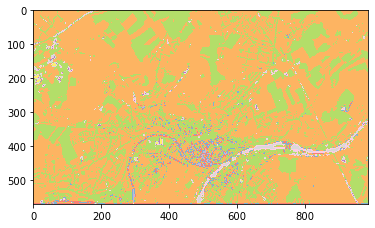

T31UFS_20200731T103629_B03_10m_ROI
A new raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/CLIPPED/T31UFS_20200731T103629_B03_10m_ROI_with_SCL.tif
T31UFS_20200731T103629_B11_10m_ROI
A new raster file is created : /Users/Nicolas/OneDrive - UCL/LBRAT2104/Output/CLIPPED/T31UFS_20200731T103629_B11_10m_ROI_with_SCL.tif


In [6]:
# Filenames
# ---------

# Get list of BOA images on which to apply the SCL

B03_im_file = f'{clipped_path}T31UFS_20200731T103629_B03_10m_ROI.tif'
B11_im_file = f'{clipped_path}T31UFS_20200731T103629_B11_10m_ROI.tif'

list_im = [B03_im_file,
           B11_im_file]

SCL_im_file = f'{clipped_path}T31UFS_20200731T103629_SCL_10m_ROI.tif'

# Parameters
# ----------

nodata_val = -10000


# APPLY SCL
# ---------

# Open SCL and change invalid pixels categories by NaN

src = rasterio.open(SCL_im_file, "r")
SCL = src.read(1)
src.close()

print('Scene Classification map')
show(SCL, cmap='Set3')

SCL = SCL.astype(float)

SCL[SCL == 0] = np.nan    # No data
SCL[SCL == 1] = np.nan    # Saturated or defective
SCL[SCL == 2] = np.nan    # Dark area pixels
SCL[SCL == 3] = np.nan    # Cloud shadows
SCL[SCL == 4] = 1         # Vegetation
SCL[SCL == 5] = 1         # Not vegetated
SCL[SCL == 6] = 1         # Water
SCL[SCL == 7] = 1         # Unclassified
SCL[SCL == 8] = np.nan    # Cloud medium probability
SCL[SCL == 9] = np.nan    # Cloud high probability
SCL[SCL == 10] = np.nan   # Thin cirrus
SCL[SCL == 11] = np.nan   # Snow


for im_file in list_im:

    # Get the output file name
    im_filename = os.path.basename(im_file)[:-4]
    im_file_scl = f'{clipped_path}{im_filename}_with_SCL.tif'

    print(im_filename)

    # Open file
    src = rasterio.open(im_file, "r")

    # Read file as numpy array
    im = src.read(1)

    # Update metadata
    profile = src.profile
    profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
                   nodata=nodata_val,     # Set nodata value in metadata
                   compress='lzw',        # Compression option
                   driver='GTiff')


    # Mask image reflectance with SCL
    im_SLC = im * SCL

    # Change numpy NaN by nodata_val (e.g. -10000)
    im_SLC[np.isnan(im_SLC)] = nodata_val

    # Change the array's type : from float to integer 16
    im_SLC = im_SLC.astype(np.int16)

    # Write image
    dst = rasterio.open(im_file_scl, 'w', **profile)
    dst.write(im_SLC, 1)

    # Close rasterio objects
    src.close()
    dst.close()

    print(f'A new raster file is created : {im_file_scl}')